<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*Wenbo*]
### ***username***: [*Yu*]
### ***CID***: [*02452289*]


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## 1. Justification of choice VAE/GAN

Explain in **two or three sentences** and/or a few **bullet points** why you have chosen to use a VAE or a GAN. There is no right or wrong choice, but the justification of the choice will be assessed.

**ANSWER:**

First of all, I initially judged and considered that the resolution of the data image is a single channel grayscale image of 32*32, and there is only one category, so a simpler VAE network may be able to achieve a better image generation effect, and because VAE is relatively easier to train than GAN network, I decided to train a simple VAE network as a BASELINE first (which can be found in section **3.1**), and then on the this basis before judging and choosing which model to complete this assignment.

After completing the testing of the VAE baseline, I found that although the shape of the generated images had a low degree of difference from the real images, the resolution of the generated images was not very satisfactory, and the generated images had a lot of severe whitening and noise, so I finally chose to build the model with a more complex GAN network.

My judgment is mainly based on the following points:

- **Image quality and resolution:** While VAEs are generally easier to train and produce images that deviate less from the original shape, the images they produce are usually of lower resolution and higher blurriness. GANs, on the other hand, are known for generating images with higher resolution and more detail, making them suitable for tasks that require higher image clarity and quality.

- **Dealing with noise and detail:** Experience with VAE models has shown that noise and loss of detail (images that are too bright, with many white spots) are serious problems. GANs can better deal with these problems as they can produce sharper images with fewer artifacts, which is essential for generating images with a high degree of reproduction.

- **Complexity and training time:** Although GANs are more complex and challenging to train, they are a better choice when the main goal is to improve image quality and resolution.

In conclusion, although VAEs are characterized by simplicity and ease of training, since the task requires higher resolution and finer images, GANs are a more suitable choice despite their higher training complexity.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install livelossplot
!pip install torchinfo
# !cp -r /content/drive/MyDrive/Dataset/real_hands.tar.gz '/content/real_hands.tar.gz'
# !tar -xzvf real_hands.tar.gz

## 2. Data preparation
This section defines functions for data preprocessing and dataset production.

### 2.1 Train-Test split functions

In [3]:
# import os
import shutil
from pathlib import Path
import os

# Directory where the images are stored
source_dir = Path("real_hands")

# Directories for train and test datasets
train_img_dir = Path("data/train_dir/hand")
test_img_dir = Path("data/test_dir/hand")

# Create the directories if they don't exist
train_img_dir.mkdir(parents=True, exist_ok=True)
test_img_dir.mkdir(parents=True, exist_ok=True)

In [4]:
from PIL import Image
import random
from matplotlib import pyplot as plt
plt.style.use('default')

def train_test_split(source_dir, train_img_dir, test_img_dir, total_images, split=1.0):
    train_images = int(total_images * split)
    # delete the files in the train_img_dir and test_img_dir
    for filename in os.listdir(train_img_dir):
        file_path = train_img_dir / filename
        if file_path.exists():
            os.remove(file_path)
    for filename in os.listdir(test_img_dir):
        file_path = test_img_dir / filename
        if file_path.exists():
            os.remove(file_path)

    for i in range(total_images):
        source_file = source_dir / f"{i:06d}.jpeg"
        if i < train_images:
            # Copy to train directory
            shutil.copy(source_file, train_img_dir)
        else:
            # Copy to test directory
            shutil.copy(source_file, test_img_dir)

    # Check the number of files in each directory to confirm
    num_train_files = len(list(train_img_dir.glob("*.jpeg")))
    num_test_files = len(list(test_img_dir.glob("*.jpeg")))

    num_train_files, num_test_files

def get_random_image(image_path, seed=42):
    # Set seed
    random.seed(seed) # <- try changing this and see what happens

    image_path = Path(image_path)
    # 1. Get all image paths (* means "any combination")
    image_path_list = list(image_path.glob("*/*/*.jpeg"))

    # 2. Get random image path
    random_image_path = random.choice(image_path_list)

    # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.stem

    # 4. Open image
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}")
    print(f"Image width: {img.width}")
    return img

# visualize original images
def visualize_raw_images(image_path, cols=10, rows=10, seed=42):
    random.seed(seed) # <- try changing this and see what happens
    image_path = Path(image_path)
    image_path_list = list(image_path.glob("*/*/*.jpeg"))
    figure = plt.figure(figsize=(8, 8))

    for i in range(cols * rows):
        random_image_path = random.choice(image_path_list)
        img = Image.open(random_image_path)
        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray")

    return image_path_list

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=10)

### 2.2 Data visualisation

train test split

In [5]:
train_test_split(source_dir, train_img_dir, test_img_dir, 8000)

visualise a random image

Random image path: data/train_dir/hand/004402.jpeg
Image class: hand
Image height: 32
Image width: 32


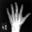

In [6]:
img = get_random_image('data', seed=42)
img

visualise raw images

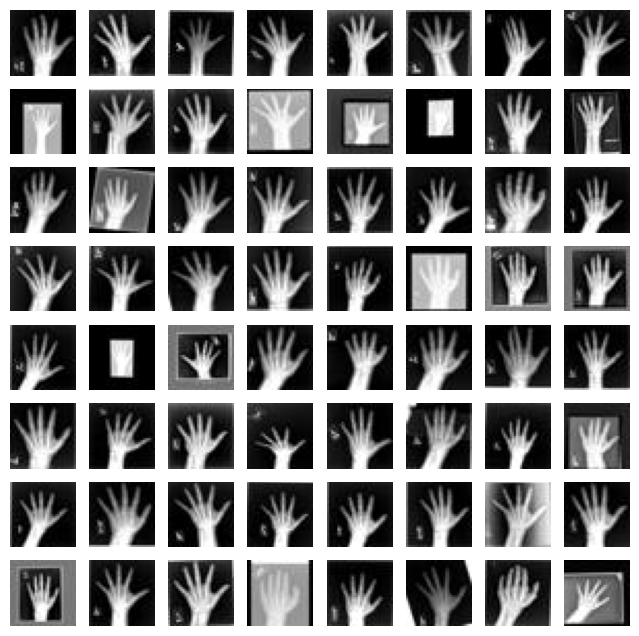

In [7]:
image_path_list = visualize_raw_images('data', cols=8, rows=8, seed=42)

### 2.3 Define data fransformer

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Write transform for image
def data_transform(shape=32, flip_prob=0.5):
    # Write transform for image
    data_transform = transforms.Compose([
        # Resize the images to 32x32
        transforms.Resize(size=(shape, shape)),
        # Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(p=flip_prob), # p = probability of flip, 0.5 = 50% chance
        # Turn the image into a torch.Tensor
        transforms.Grayscale(),
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ])
    return data_transform

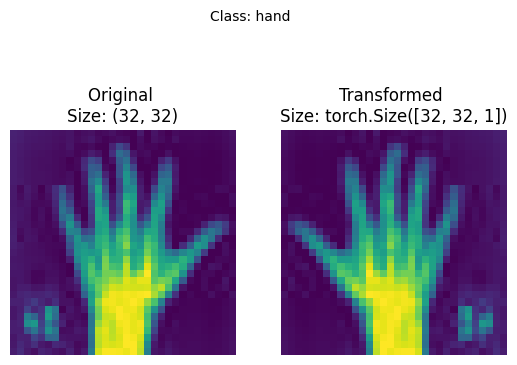

In [13]:
plot_transformed_images(image_path_list,
                        transform=data_transform(),
                        n=1, seed=42)

In [14]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_dir = Path("data/train_dir")
test_dir = Path("data/test_dir")
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform(), # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

# test_data = datasets.ImageFolder(root=test_dir,
#                                  transform=data_transform)
print(f"Train data:\n{train_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8000
    Root location: data/train_dir
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               Grayscale(num_output_channels=1)
               ToTensor()
           )


In [15]:
class_names = train_data.classes
class_names

['hand']

In [16]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'hand': 0}

In [17]:
# Check the lengths
len(train_data)

8000

In [18]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([1, 32, 32])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [19]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?
# test_dataloader = DataLoader(dataset=test_data,
#                              batch_size=BATCH_SIZE,
#                              num_workers=1,
#                              shuffle=False) # don't usually need to shuffle testing data
train_dataloader

In [20]:
img, label = next(iter(train_dataloader))
# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 3. Network design and implementation

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import random

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

### 3.1 Baseline Model (simple VAE model)

Here is a simple VAE model for a preliminary analysis of the data as a means of determining which model to choose for this coursework.

#### 3.1.1 Simple VAE Model (baseline model)

In [22]:
class VAE_Encoder(nn.Module):
  def __init__(self,
               num_classes=1):
    '''
    Class contains the Encoder (image -> latent).
    '''

    super(VAE_Encoder, self).__init__()
    self.layer0 = nn.Linear(32*32 + num_classes, 512)  # Image to hidden, fully connected
    self.transform0 = nn.ReLU()
    self.layer1 = nn.Linear(512, 256)  # Image to hidden, fully connected
    self.transform1 = nn.ReLU()

  def forward(self, x, y):  # Custom pytorch modules should follow this structure
    '''
    x: [float] the MNIST image
    '''

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D)
    x = torch.cat([x, y], dim=1)  # Concatenate the image and the class (one-hot vector
    x = self.transform0(self.layer0(x))  # Run Image through Linear transform then ReLu activation function
    x = self.transform1(self.layer1(x))  # Run Image through Linear transform then ReLu activation function
    return x

class VAE_Decoder(nn.Module):
  def __init__(self,
               num_classes=1):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()
    self.layer1 = nn.Linear(256 + num_classes, 512)  # Connectivity Latent to Hidden
    self.activation1 = nn.ReLU()
    self.layerOut = nn.Linear(512, 32*32)  # Connectivity Hidden to Image
    self.activationOut = nn.Sigmoid()

  def forward(self, z, y):
    '''
    z: [float] a sample from the latent variable
    '''

    z = torch.cat([z, y], dim=1)  # Concatenate the latent vector and the class (one-hot vector)
    z = self.activation1(self.layer1(z))  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape((-1,1,32,32))  # Reshape the vector into an image

class VariationalAutoencoder(nn.Module):
  def __init__(self, dims_latent, num_classes=1):
    '''
    Class combines the Encoder and the Decoder.

    dims_latent: [int] the dimension of (number of nodes in) the mean-field gaussian latent variable
    '''

    super(VariationalAutoencoder, self).__init__()
    self.encoder = VAE_Encoder()
    self.decoder = VAE_Decoder()

    self.layerMu = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.layerSig = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

    self.latentOut = nn.Linear(dims_latent, 256)  # Connectivity Latent to Hidden
    self.activationOut = nn.ReLU()


  def vae_latent_space(self, x):
    mu =  self.layerMu(x)  # Turn the output of the Encoder into Mu
    sigma = torch.exp(self.layerSig(x))  # Exponential activation ensures positivity for Sigma
    z = mu + sigma * self.distribution.sample(mu.shape).to(device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # Calculate the KL divergence
    return z, kl_div  # z shape is (batch_size, dims_latent)

  def forward(self, x, y):
    x = self.encoder(x, y)
    z, kl_div = self.vae_latent_space(x)
    z = self.activationOut(self.latentOut(z))  # Take the latent vector and make the input for the Decoder
    return self.decoder(z, y), kl_div

In [23]:
from livelossplot import PlotLosses
from torch import tensor
from tqdm.auto import tqdm
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               target_dir: str,
               model_name: str,
               epoch=None,
               info=False):
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model path
  if epoch is not None:
    model_name = f"{model_name}_{epoch}.pth"
  else:
    model_name = f"{model_name}.pth"

  model_save_path = target_dir_path / model_name
  # Save the model state_dict()
  if info:
    print(f"[INFO] Saving model to: {model_save_path}")
  # torch.save(obj=model.state_dict(),
  #            f=model_save_path)

  checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
  }

  torch.save(obj=checkpoint, f=model_save_path)

def plot_sample(autoencoder, y, device='cpu'):
    z = torch.randn([1,2]).to(device).float()
    y = torch.nn.functional.one_hot(tensor([y]), 1)[0].to(device).float().unsqueeze(0)
    img = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z)), y).to('cpu').detach().numpy()[0,0]
    return img

def train(autoencoder, data, kl_div_on=True, epochs=1, device='cpu', checkpoint=None, save_inv=5):
  opt = torch.optim.Adam(autoencoder.parameters())
  starting_epoch = 0
  liveloss = PlotLosses()  # Initialize liveloss
  if checkpoint:
    autoencoder.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    starting_epoch = checkpoint['epoch']
    # liveloss loads the previous epoch
    for epoch in range(starting_epoch + 1):
      liveloss.update({})

  # liveloss.update
  for epoch in tqdm(range(starting_epoch, starting_epoch + epochs), initial=starting_epoch, total=starting_epoch + epochs):
  # for epoch in tqdm(range(epochs)):  # Run data over numerous epochs
    current_epoch = epoch + 1
    logs = {}
    running_loss = 0.0
    for batch, label in data:  # Iterate over the batches of images and labels
      batch = batch.to(device)  # Send batch of images to the GPU
      # print(batch.shape)
      # print(label)
      # print(batch.shape)
      y = torch.nn.functional.one_hot(label, 1).to(device)

      opt.zero_grad()  # Set optimiser grad to 0

      x_hat, KL = autoencoder(batch, y)  # Generate predicted images (x_hat) by running batch of images through autoencoder

      loss = ((batch - x_hat)**2).sum() + KL  # Calculate combined loss
      running_loss += loss.item()
      loss.backward()  # Back-propagate

      opt.step()  # Step the optimiser

    average_loss = running_loss / len(data)
    logs['loss'] = average_loss
    liveloss.update(logs)
    liveloss.send()

    # save model every 5 epochs with a different
    if current_epoch % save_inv == 0:
      print('epoch = '+str(current_epoch))
      save_model(model=autoencoder, optimizer=opt, target_dir='models/VAE', model_name='vae', epoch=current_epoch, info=True)
  # return autoencoder  # Return the trained autoencoder (for later analysis)
def vae_show_images(autoencoder, device='cpu', cols=10, rows=10):
    figure = plt.figure(figsize=(10, 10))

    for i in range(cols * rows):
        img = plot_sample(autoencoder, 0)
        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

#### 3.1.2 Train baseline model

In [24]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_test_split(source_dir, train_img_dir, test_img_dir, 8000, split=0.8)

train_dir = Path("data/train_dir")
test_dir = Path("data/test_dir")

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform(), # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

# Turn train and test Datasets into DataLoaders

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

print(len(train_dataloader), len(test_dataloader))

200 50


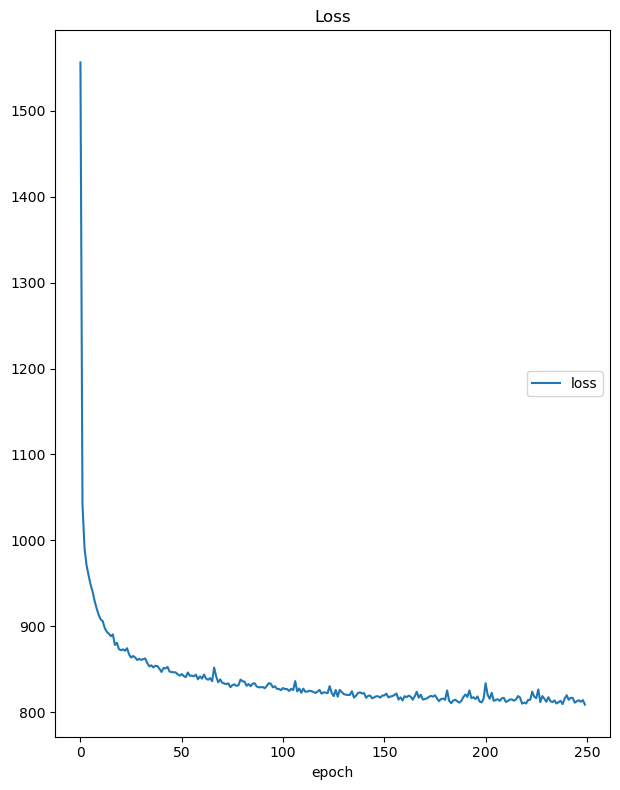

100%|██████████| 250/250 [06:36<00:00,  1.58s/it]

Loss
	loss             	 (min:  808.942, max: 1556.130, cur:  808.942)
epoch = 250
[INFO] Saving model to: models/VAE/vae_250.pth
done


In [ ]:
dims_latent = 2  # Maybe increase this an try the t-sne algorithm for visualisation?!
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
VAE = VariationalAutoencoder(dims_latent).to(device)
train(VAE, data=train_dataloader, epochs=250, device=device, save_inv=5)
print('done')

#### 3.1.3 Visualise baseline results

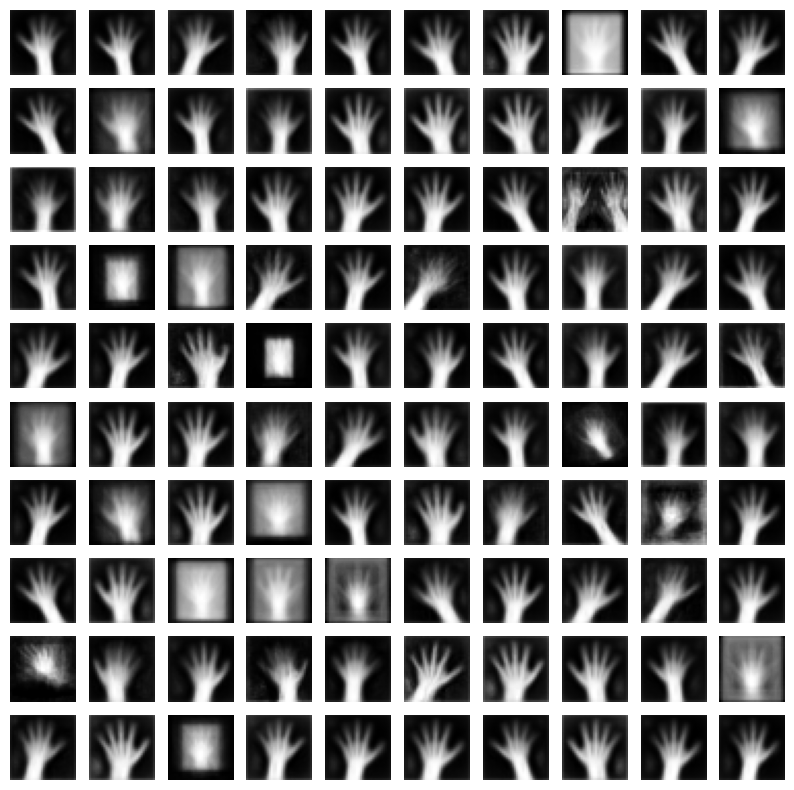

In [ ]:
checkpoint1 = torch.load('models/VAE/vae_250.pth')
VAEtmp = VariationalAutoencoder(dims_latent).to('cpu')
VAEtmp.load_state_dict(checkpoint1['model_state_dict'])
VAEtmp.eval()
torch.manual_seed(42)
vae_show_images(VAEtmp)

### 3.2 DCGAN model implementation

In [26]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import random
from torch import tensor
from tqdm.auto import tqdm
from PIL import Image
from torch import optim
import torchvision
# from torchinfo import summary
# import seaborn as sns

class Generator(nn.Module):
    """
    The Generator class is a neural network that generates new images.

    Parameters
    ----------
    channels_noise : int, optional
        The number of input channels (noise), by default 100
    num_units : int, optional
        The number of units in the hidden layer, by default 32
    """

    def __init__(self, channels_noise=100, num_units=32):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # hidden layers
            self._hidden_block(channels_noise, num_units*4, 4, 1, 0), # 4x4
            self._hidden_block(num_units*4, num_units*2, 4, 2, 1),    # 8x8
            self._hidden_block(num_units*2, num_units, 4, 2, 1),      # 16x16
            # output Layer
            nn.ConvTranspose2d(in_channels=num_units,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),  # 32x32
            nn.Tanh()  # normalize inputs
        )

    def _hidden_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size,
                               stride,
                               padding,
                               bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),  # relu is used to avoid sparse gradients
        )

    def forward(self, x):
        x = self.main(x)
        return x

class Discriminator(nn.Module):
    """
    The Discriminator class is a neural network that classifies images as real or fake.

    Parameters
    ----------
    channels_img : int, optional
        The number of input channels (image), by default 1
    num_units : int, optional
        The number of units in the hidden layer, by default 32
    """

    def __init__(self, channels_img=1, num_units=32):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1ch x 32w x 32h
            nn.Conv2d(in_channels=channels_img,
                      out_channels=num_units,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            # hidden layers
            self._hidden_block(num_units, num_units*2, 4, 2, 1),    # 16x16
            self._hidden_block(num_units*2, num_units*4, 4, 2, 1),  # 8x8
            # Output layer
            nn.Conv2d(in_channels=num_units*4,  # 4x4
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),              # 1x1
            nn.Sigmoid()
        )
    def _hidden_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2),  # leaky relu is used to avoid sparse gradients
        )

    def forward(self, x):
        x = self.main(x)
        return x

## 4. Training and evaluation loops

This section implements the functions for GAN training and testing and implements the saving of checkpoints during training. The model can be easily trained by using the `GAN_train()` function.

In addition, the loading and retraining of the model and the evaluation of the network are modularized by the repartitioning. The trained model can be loaded and further retraining by using the same `GAN_train()` function with an additional parameter `checkpoint`.

In [ ]:
# !pip install torchinfo

In [27]:
from torch import tensor
from tqdm.auto import tqdm
from livelossplot import PlotLosses
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision
# from torchinfo import summary
# import seaborn as sns

def GAN_train(G: torch.nn.Module,
              D: torch.nn.Module,
              G_optimizer: torch.optim.Optimizer,
              D_optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              test_noise: torch.Tensor,
              data_loader: torch.utils.data.DataLoader,
              device='cpu',
              n_epochs=5,
              checkpoint=None,
              target_dir='./models/GAN/',
              model_name='dcgan',
              save_inv=5,
              D_losses=None,
              G_losses=None,):
    target_dir = Path(target_dir) / model_name
    if D_losses is None:
      D_losses = []
    if G_losses is None:
      G_losses = []
    start_epoch = 0
    groups = {'Loss': ['D_Loss', 'G_Loss']}
    liveloss = PlotLosses(groups=groups)
    liveloss.update({})

    # load checkpoint if specified
    if checkpoint is not None:
        G, D, G_optimizer, D_optimizer, start_epoch, _, _ = GAN_load_model(G, D, G_optimizer, D_optimizer, checkpoint)
        # liveloss loads the previous epoch
        for epoch in range(start_epoch + 1):
          liveloss.update({})
    # training loop
    for epoch in tqdm(range(start_epoch, start_epoch + n_epochs), initial=start_epoch, total=start_epoch + n_epochs):
        current_epoch = epoch + 1
        logs = {}

        # print(f"Epoch: {current_epoch}/{start_epoch + n_epochs}")
        print("Example images:")
        generated_images = G(test_noise).detach().to('cpu')
        show_images(generated_images)

        D_loss , G_loss = 0.0, 0.0
        # batch loop
        for idx, (batch, _) in enumerate(data_loader):
            # print(f"\rEpoch: {epoch}\tBatch: {i}/{len(train_dataloader)}", end='')
            ## Train the discriminiator ##
            D.train()
            D_optimizer.zero_grad()

            # Compute error on real data
            real = Variable(batch).to(device)
            real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
            real_predictions = D(real)
            d_error_real = loss_fn(real_predictions, real_labels)

            # Compute error on fake data
            noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(device)
            fake = G(noise)
            fake_predictions = D(fake.detach())
            fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(device)
            d_error_fake = loss_fn(fake_predictions, fake_labels)

            # Accumulate and backpropogate on combined error
            d_error_total = d_error_real + d_error_fake
            d_error_total.backward()
            D_optimizer.step()

            ## Train the generator ##
            G.train()
            G_optimizer.zero_grad()

            # Compute rate of fakes being detected
            goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
            results = D(fake)
            g_error = loss_fn(results, goal_labels)

            # Backpropogate and update weights
            g_error.backward()
            G_optimizer.step()

            D_loss += d_error_total.data.item()
            G_loss += g_error.data.item()

        D_loss /= len(data_loader)
        G_loss /= len(data_loader)
        D_losses.append(D_loss)
        G_losses.append(G_loss)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss

        # change liveloss figure size
        plt.rcParams['figure.figsize'] = [5, 5]
        liveloss.update(logs)
        liveloss.draw()

        # save model every save_inv epochs
        if current_epoch % save_inv == 0:
            print(target_dir)
            GAN_save_model(G, D, G_optimizer, D_optimizer, target_dir, model_name, epoch=current_epoch, D_loss=D_loss, G_loss=G_loss)

    return D_losses, G_losses, start_epoch, n_epochs

def GAN_save_model(G: torch.nn.Module,
                   D: torch.nn.Module,
                   G_optimizer : torch.optim.Optimizer,
                   D_optimizer : torch.optim.Optimizer,
                   target_dir: str,
                   model_name: str,
                   epoch=None,
                   G_loss=None,
                   D_loss=None,
                   info=False):
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model path
  if epoch is not None:
    model_name = f"{model_name}_{epoch}.pth"
  else:
    model_name = f"{model_name}.pth"

  model_save_path = target_dir_path / model_name
  # Save the model state_dict()
  if info:
    print(f"[INFO] Saving model to: {model_save_path}")

  checkpoint = {
    'G_state_dict': G.state_dict(),
    'D_state_dict': D.state_dict(),
    'G_optimizer_state_dict': G_optimizer.state_dict(),
    'D_optimizer_state_dict': D_optimizer.state_dict(),
    'epoch': epoch,
  }
  if G_loss is not None:
    checkpoint['G_loss'] = G_loss
  if D_loss is not None:
    checkpoint['D_loss'] = D_loss
  torch.save(obj=checkpoint, f=model_save_path)

# load GAN model from checkpoint function
def GAN_load_model(G: torch.nn.Module,
                   D: torch.nn.Module,
                   G_optimizer : torch.optim.Optimizer,
                   D_optimizer : torch.optim.Optimizer,
                   checkpoint_path: str,
                   info=False):
  # Load checkpoint
  checkpoint = torch.load(checkpoint_path)
  # Load model weights
  G.load_state_dict(checkpoint['G_state_dict'])
  D.load_state_dict(checkpoint['D_state_dict'])
  # Load optimizer state
  G_optimizer.load_state_dict(checkpoint['G_optimizer_state_dict'])
  D_optimizer.load_state_dict(checkpoint['D_optimizer_state_dict'])
  # Load epoch
  epoch = checkpoint['epoch']
  # Load loss
  G_loss, D_loss = None, None
  if 'G_loss' in checkpoint:
    G_loss = checkpoint['G_loss']
  if 'D_loss' in checkpoint:
    D_loss = checkpoint['D_loss']
  if info:
    print(f"[INFO] Loading checkpoint from: {checkpoint_path}")
    print(f"[INFO] Loaded checkpoint at epoch: {epoch}")

  return G, D, G_optimizer, D_optimizer, epoch, G_loss, D_loss

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

def GAN_results(G: torch.nn.Module,
                D: torch.nn.Module,
                loss_fn: torch.nn.Module,
                train_dataloader,
                test_num=1000,
                device='cpu',
                seed=42):
    set_seed(seed)
    D_loss, G_loss = 0.0, 0.0
    with torch.inference_mode():
      for idx, (batch, _) in enumerate(train_dataloader):
          D.eval()
          # Compute error on real data
          real = Variable(batch).to(device)
          real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
          real_predictions = D(real)
          d_error_real = loss_fn(real_predictions, real_labels)

          # Compute error on fake data
          noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(device)
          fake = G(noise)
          fake_predictions = D(fake.detach())
          fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(device)
          d_error_fake = loss_fn(fake_predictions, fake_labels)

          # Accumulate and backpropogate on combined error
          d_error_total = d_error_real + d_error_fake
          ## Train the generator ##
          G.eval()

          # Compute rate of fakes being detected
          goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
          results = D(fake)
          g_error = loss_fn(results, goal_labels)

          D_loss += d_error_total.data.item()
          G_loss += g_error.data.item()
          if idx > test_num:
            break
      D_loss /= test_num
      G_loss /= test_num
    return D_loss, G_loss

In [28]:
device = 'cpu'
G = Generator().to(device)
D = Discriminator().to(device)
# Create an optimizer to update the weights of each network
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [31]:
G, D

(Generator(
   (main): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (4): Tanh()
   )
 ),
 Discriminator(
   (main): Sequential(
     (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): Le

In [32]:
test_noise = torch.randn((8, 100, 1, 1)).to(device)
test_noise.shape
G(test_noise).shape

torch.Size([8, 1, 32, 32])

In [33]:
image_noise = torch.randn((8, 1, 32, 32)).to(device)
image_noise.shape
D(image_noise).shape

torch.Size([8, 1, 1, 1])

add text blocks as you need

## 5. Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

This section will select the optimal model for the implementation of the complete training workflow.

**Please note** that due to time constraints, it is normal that the execution results of the code blocks shown here do not coincide with the training epoch of the final model, so the model used in the final result, i.e., the sample image generation section, is the model imported from one of the training checkpoints, as described in the subsequent notes.



### 5.1 Dataset and Dataloader

In [34]:
from torchvision import datasets
from torch.utils.data import DataLoader
train_test_split(source_dir, train_img_dir, test_img_dir, 8000)
train_dir = Path("data/train_dir")
BATCH_SIZE = 32

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform(), # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

print(f"Number of training examples: {len(train_data)}")
print(f"Number of batches: {len(train_dataloader)}")

Number of training examples: 8000
Number of batches: 250


### 5.2 Define hyperparameters and training

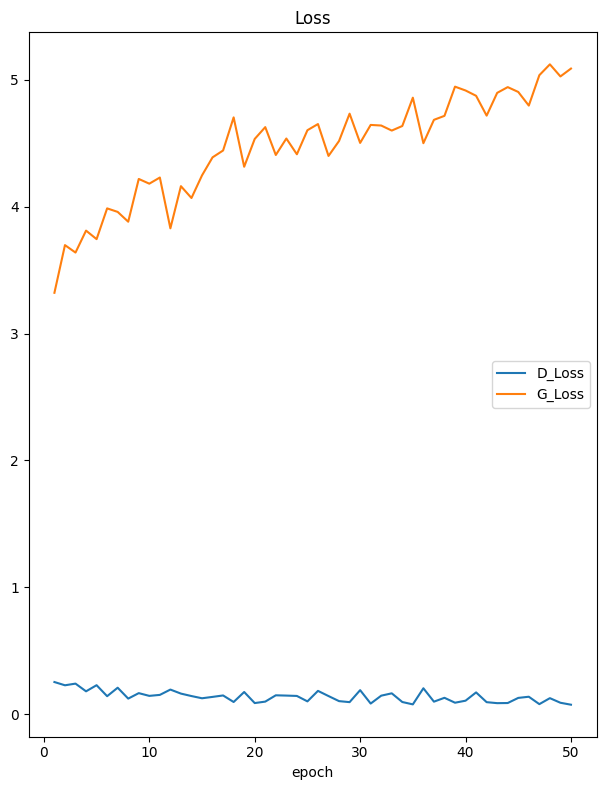

Loss
	D_Loss           	 (min:    0.076, max:    0.255, cur:    0.076)
	G_Loss           	 (min:    3.321, max:    5.121, cur:    5.087)
models/GAN/dcgan_v_final


In [35]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")

# Hyperparameters
NUM_UNITS = 32
CHANNELS_NOISE = 100
LR = 0.0002
BATAS = (0.5, 0.999)
loss_fn = nn.BCELoss()

# Create the networks
G_final = Generator(num_units=NUM_UNITS).to(device)
D_final = Discriminator(num_units=NUM_UNITS).to(device)
# Create an optimizer to update the weights of each network
g_optimizer_final = optim.Adam(G_final.parameters(), lr=LR, betas=BATAS)
d_optimizer_final = optim.Adam(D_final.parameters(), lr=LR, betas=BATAS)
# Create a noise vector to feed into the generator
test_noise = torch.randn((8, 100, 1, 1)).to(device)

D_losses_final, G_losses_final = [], []
D_losses_final, G_losses_final, start_epoch_final, n_epochs_final = GAN_train(G=G_final,
                                                        D=D_final,
                                                        G_optimizer=g_optimizer_final,
                                                        D_optimizer=d_optimizer_final,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=50,   # please modify this before running here is just a demo for the final report
                                                        save_inv=10,
                                                        model_name='dcgan_v_final',
                                                        D_losses=D_losses_final,
                                                        G_losses=G_losses_final)

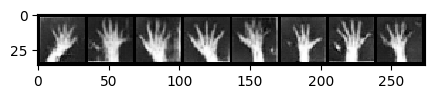

In [36]:
generated_images = G_final(test_noise).detach().to('cpu')
show_images(generated_images)

### 5.3 Loda model from checkpoint and retrain

It is easy to retrain the previous model using the `GAN_train()` function with a checkpoint.

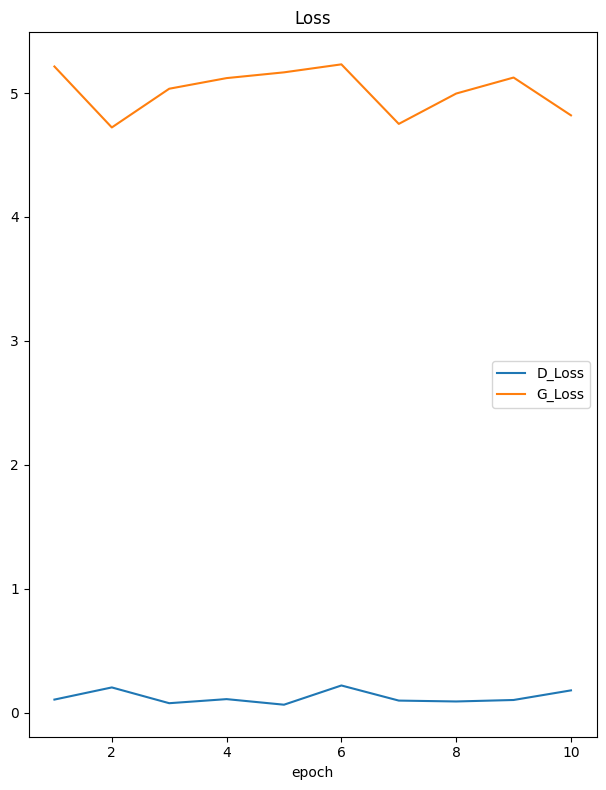

Loss
	D_Loss           	 (min:    0.064, max:    0.219, cur:    0.180)
	G_Loss           	 (min:    4.722, max:    5.232, cur:    4.820)
models/GAN/dcgan_v_final


In [37]:
# retrain
D_losses_final, G_losses_final = [], []
D_losses_final, G_losses_final, start_epoch_final, n_epochs_final = GAN_train(G=G_final,
                                                        D=D_final,
                                                        G_optimizer=g_optimizer_final,
                                                        D_optimizer=d_optimizer_final,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=10,   # please modify this before running here is just a demo for the final report
                                                        save_inv=10,
                                                        model_name='dcgan_v_final',
                                                        D_losses=D_losses_final,
                                                        G_losses=G_losses_final)

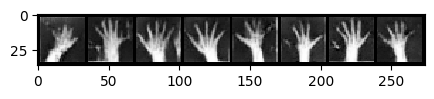

In [38]:
generated_images = G_final(test_noise).detach().to('cpu')
show_images(generated_images)

### 5.4(*) Previous training block

This is a code block from a previous training. Please ignore the error. It is only used to show the training process.

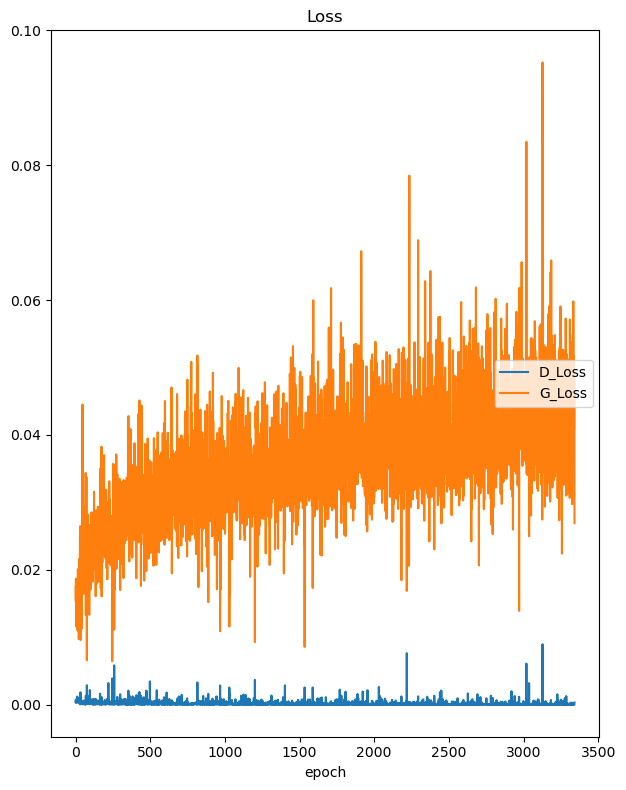

 33%|███▎      | 3341/10000 [5:25:43<11:07:51,  6.02s/it]

Loss
	D_Loss           	 (min:    0.000, max:    0.009, cur:    0.000)
	G_Loss           	 (min:    0.006, max:    0.095, cur:    0.027)
Example images:


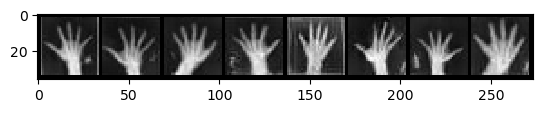

 33%|███▎      | 3341/10000 [5:25:44<10:49:14,  5.85s/it]


KeyboardInterrupt: 

In [ ]:
# # previous training block
# G = Generator().to(device)
# D = Discriminator().to(device)
# # Create an optimizer to update the weights of each network
# g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# test_noise = torch.randn((8, 100, 1, 1)).to(device)
# D_losses, G_losses, start_epoch, n_epochs = GAN_train(G=G,
#                                                         D=D,
#                                                         G_optimizer=g_optimizer,
#                                                         D_optimizer=d_optimizer,
#                                                         loss_fn=loss_fn,
#                                                         test_noise=test_noise,
#                                                         data_loader=train_dataloader,
#                                                         device=device,
#                                                         n_epochs=10000,
#                                                         save_inv=50,
#                                                         model_name='dcgan_v1')

## 6. Generate 300 new samples with your trained network

In [ ]:
IMG_SEED = 4

In [ ]:
def generate_samples(G: torch.nn.Module,
                     cols=30,
                     rows=10,
                     x=20,
                     y=8,
                     seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    noise = torch.randn((300, 100, 1, 1)).to(device)
    generated_images = G(noise).detach().to('cpu')

    figure = plt.figure(figsize=(x, y))
    for i in range(cols * rows):
        img = generated_images[i]
        figure.add_subplot(rows, cols, i+1)
        # plt.title(labels_map[i%10])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

In [ ]:
G_trained = Generator().to(device)
D_trained = Discriminator().to(device)
# Create an optimizer to update the weights of each network
g_optimizer_trained = optim.Adam(G_trained.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer_trained = optim.Adam(D_trained.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_trained, D_trained, g_optimizer_trained, d_optimizer_trained, epoch_trained, _, _ = GAN_load_model(G=G_trained,
                                                            G_optimizer=g_optimizer_trained,
                                                            D=D_trained,
                                                            D_optimizer=d_optimizer_trained,
                                                            checkpoint_path="model_best/dcgan_v1_6000.pth",
                                                            info=True)

[INFO] Loading checkpoint from: model_best/dcgan_v1_6000.pth
[INFO] Loaded checkpoint at epoch: 6000


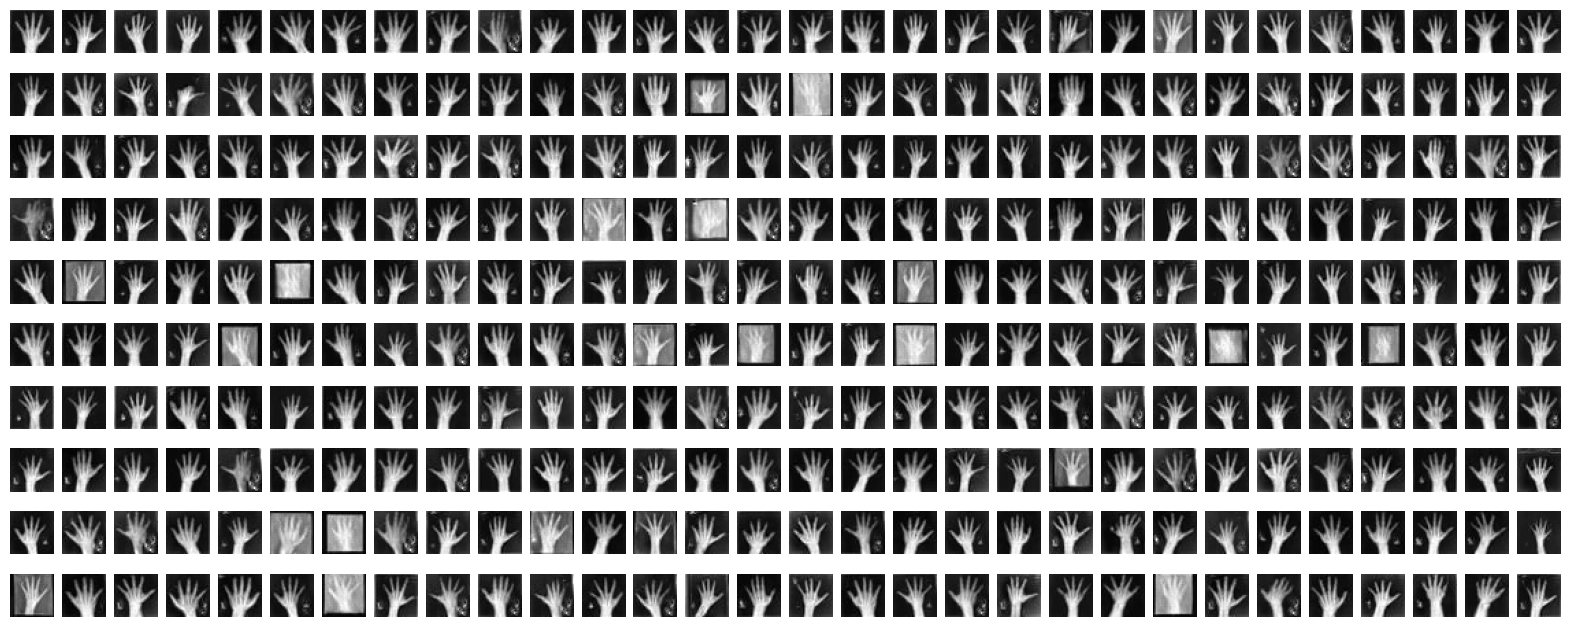

In [ ]:
generate_samples(G_trained, seed=IMG_SEED, cols=30, rows=10)

## 7. Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

add text blocks as you need

In [ ]:
def GAN_save_images(G:nn.Module,
                    model_name: str,
                    n_images=10,
                    target_dir='GAN_hands',
                    device='cpu',
                    seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    # Create target directory
    G.eval().to(device)
    target_dir_path = Path(target_dir+'/'+model_name)
    target_dir_path.mkdir(parents=True, exist_ok=True)
    # Generate images
    noise = Variable(torch.randn(n_images, 100, 1, 1)).to(device)
    generated_images = G(noise).detach().to(device)
    # Save images
    for i in range(n_images):
        img = generated_images[i][0]
        image_data = (img - img.min()) / (img.max() - img.min()) # rescale to 0-1
        image_data = image_data.detach().numpy()
        image_data = (image_data * 255).astype('uint8')  # rescale to 0-255
        img = Image.fromarray(image_data, mode='L')  # L is for grayscale
        img.save(target_dir_path / f"acse-wy1223_GAN{i+1:03d}.jpeg")
        # plt.imshow(img, cmap='gray')
        # plt.axis('off')
        # plt.show()

def visualize_saved_images(image_path, cols=10, rows=10, seed=42):
    # random.seed(seed) # <- try changing this and see what happens
    image_path = Path(image_path)
    image_path_list = list(image_path.glob("*.jpeg"))
    image_path_list.sort()
    figure = plt.figure(figsize=(20, 8))

    for i in range(cols * rows):
        img = Image.open(image_path_list[i])
        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        # set title as class name
        plt.title(image_path_list[i].name[-8:-5], fontsize=8, loc='center')
        plt.imshow(img, cmap="gray")
    return image_path_list

In [ ]:
G_best = Generator().to(device)
D_best = Discriminator().to(device)
# Create an optimizer to update the weights of each network
g_optimizer_best = optim.Adam(G_best.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer_best = optim.Adam(D_best.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_best, D_best, g_optimizer_best, d_optimizer_best, epoch_best, _, _ = GAN_load_model(G=G_best,
                                                            G_optimizer=g_optimizer_best,
                                                            D=D_best,
                                                            D_optimizer=d_optimizer_best,
                                                            checkpoint_path="model_best/dcgan_v1_6000.pth",
                                                            info=True)

[INFO] Loading checkpoint from: model_best/dcgan_v1_6000.pth
[INFO] Loaded checkpoint at epoch: 6000


In [ ]:
GAN_save_images(G=G_best, model_name='dcgan_v1', n_images=300, target_dir='GAN_hands', device=device, seed=IMG_SEED)

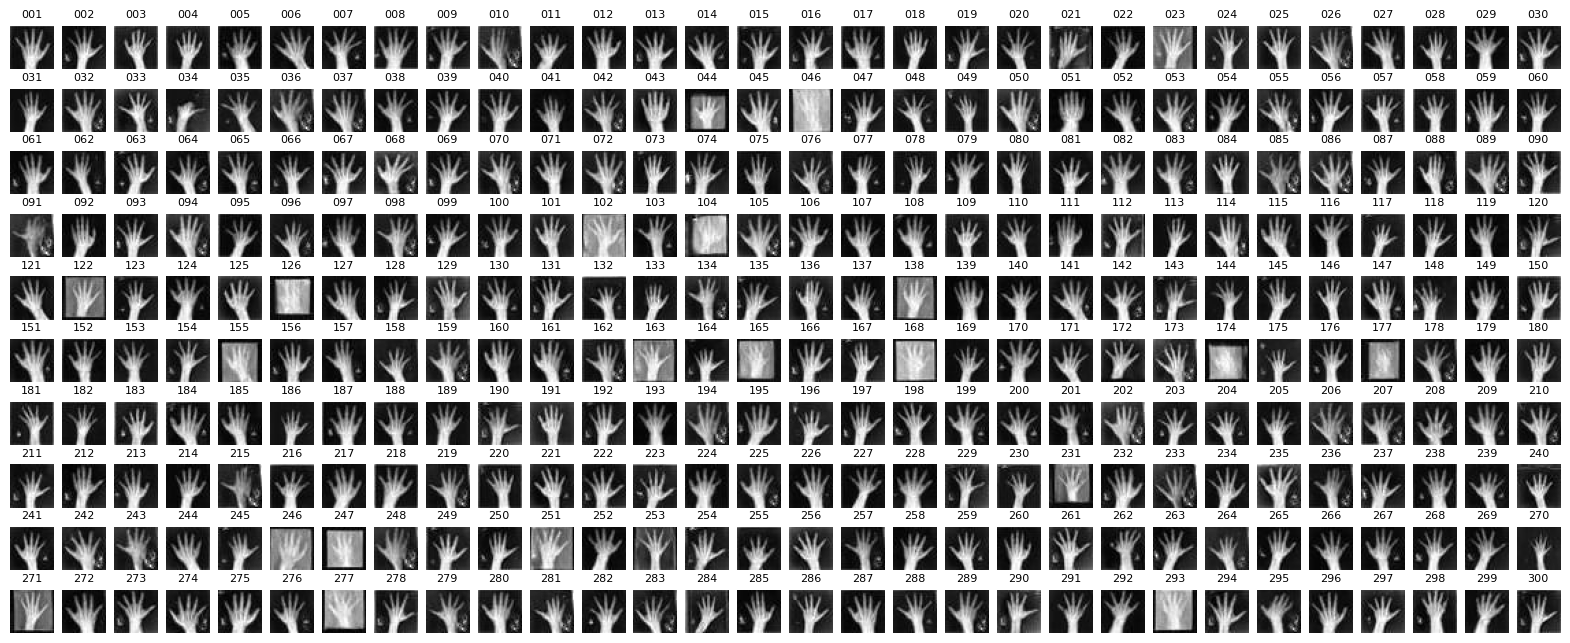

In [ ]:
images_save_path = Path('GAN_hands/dcgan_v1')
image_path_list = visualize_saved_images(images_save_path, cols=30, rows=10, seed=42)